# Haser coma model

The [Haser (1957)](https://ui.adsabs.harvard.edu/#abs/1957BSRSL..43..740H/abstract) model calculates the spatial distribution of coma molecules under photolysis.

## Column density versus radial distance
To model the distribution of CO$_2$ in a coma at 1 au from the Sun, use `Haser.column_density`.

### Top-level imports and bibliography tracking

In [1]:
import numpy as np

import astropy.units as u

from sbpy.activity import gas
from sbpy import bib

bib.track()

### Calculate

Calculate the Haser model column density from 1 to $10^4$ km for CO$_2$ at 1 au, produced at a rate of $10^{28}$/s.  Let the expansion velocity be 0.8 km/s.

In [2]:
Q = 1e28 / u.s  # CO2 production rate
v = 0.8 * u.km / u.s  # gas radial expansion speed

rh = 1.0 * u.au  # heliocentric distance
tau = gas.photo_timescale('CO2', source='CE83') # Crovisier & Encrenaz 1983
gamma = v * tau * (rh / u.au)**2
print('lengthscale = {:.0g}\n'.format(gamma))

co2 = gas.Haser(Q, v, gamma)

for rho in 10**np.arange(0, 5) * u.km:  # projected radial distance from the nucleus
    print('{:10.1f} {:10.2e}'.format(rho, co2.column_density(rho)))

lengthscale = 4e+05 km

       1.0 km   3.12e+21 1 / m2
      10.0 km   3.12e+20 1 / m2
     100.0 km   3.12e+19 1 / m2
    1000.0 km   3.09e+18 1 / m2
   10000.0 km   2.89e+17 1 / m2


### Plot the distribution of CO$_2$ as a function of heliocentric distance.

<IPython.core.display.Javascript object>


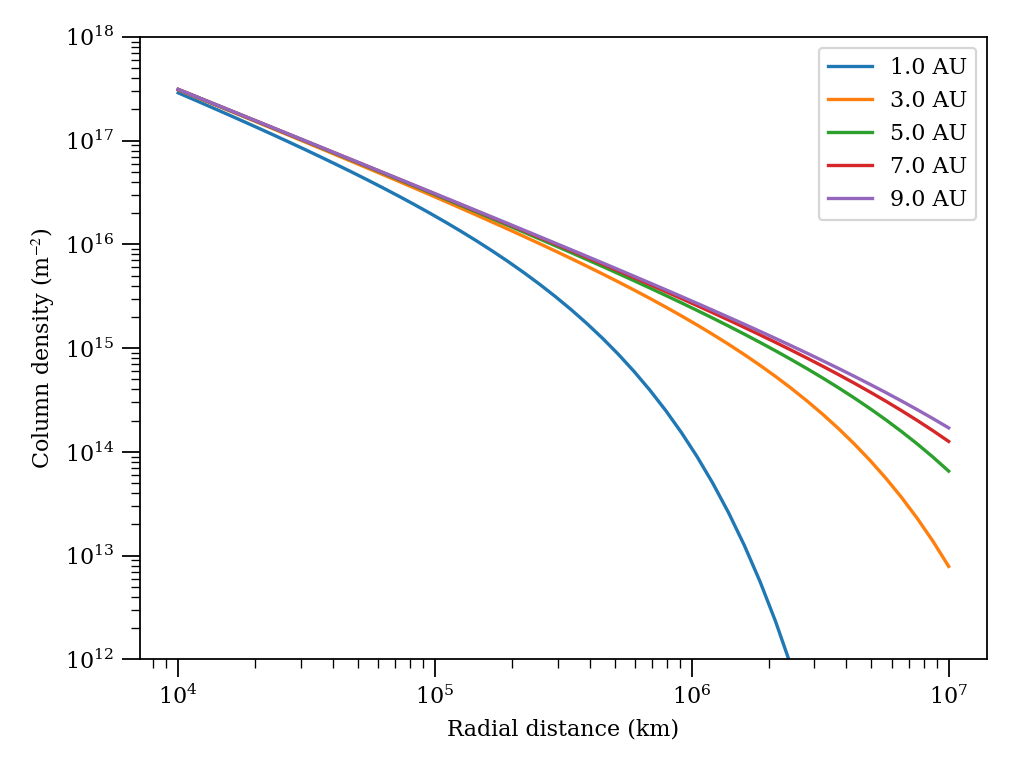

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

rho = np.logspace(4, 7) * u.km

fig = plt.figure(1)
fig.clear()
ax = fig.gca()

for rh in np.arange(1, 11, 2) * u.au:
    gamma = v * tau * (rh / u.au)**2
    co2 = gas.Haser(Q, v, gamma)
    ax.plot(rho, co2.column_density(rho), label='{:.1f}'.format(rh))
    
plt.setp(ax, xlabel='Radial distance (km)', xscale='log',
         ylabel='Column density (m$^{-2}$)', ylim=(1e12, 1e18), yscale='log')
ax.legend()
plt.tight_layout()

## Fragment species and production rate

To model a fragment species produced in the coma, provide the lengthscales of the parent and daughter to `Haser`.  sbpy has some effective lengthscales available:  Water and OH from [Cochran & Schleicher (1993)](https://ui.adsabs.harvard.edu/?#abs/1993Icar..105..235C).

### Number within an aperture

In [5]:
Q = 1e28 / u.s
v = 1.0 * u.km / u.s
gamma_H2O = gas.photo_lengthscale('H2O', source='CS93')
gamma_OH = gas.photo_lengthscale('OH', source='CS93')

H2O = gas.Haser(Q, v, gamma_H2O)
OH = gas.Haser(Q, v, gamma_H2O, gamma_OH)

rho = 1e4 * u.km
print('''
Total number within {}

  H2O = {:.4g}
   OH = {:.4g}
'''.format(rho, H2O.total_number(rho), OH.total_number(rho)))



Total number within 10000.0 km

  H2O = 1.048e+32
   OH = 4.539e+31



### Production rate

Reproduce the OH production rates for comet 46P/Wirtanen from [Farnham & Schleicher 1998](https://ui.adsabs.harvard.edu/#abs/1998A&A...335L..50F/abstract).

In [6]:
# OH production rates from Farnham & Schleicher 1998
f98 = 10**np.array((27.89, 27.87, 27.84)) / u.s

eph = {
    'rh': [1.118, 1.137, 1.071] * u.au,
    'delta': [1.409, 1.600, 1.536] * u.au,
    'rdot': [5.7, -8.1, -2.7] * u.km / u.s
}
rho = 10**np.array((4.29, 4.64, 4.49)) * u.km  # aperture radii
fluxd = 10**np.array((-10.49, -10.34, -10.47)) * u.erg / u.cm**2 / u.s  # observed flux density

# luminosity per molecule at 1 au for the 0-0 band at the 
# comet's heliocentric radial velocity and distance from the Sun
L_N = gas.fluorescence_band_strength('OH 0-0', eph, source='SA88')

Q1 = 1 / u.s
v = 1.0 * u.km / u.s

Q = np.zeros_like(f98)
for i in range(len(Q)):
    parent = gamma_H2O * (eph['rh'][i] / u.au)**2
    daughter = gamma_OH * (eph['rh'][i] / u.au)**2

    OH = gas.Haser(Q1, v, parent, daughter)               
    N = OH.total_number(rho[i])

    Q[i] = Q1 * fluxd[i] / (L_N[i] * N / 4 / np.pi / eph['delta'][i]**2)
    Q[i] = Q[i].to(f98.unit)

print('Calculated OH production rates:', Q)
print('Mean percent difference from F&S98: {:.1%}'.format(np.mean(np.abs(Q - f98) / f98)))

Calculated OH production rates: [7.64057776e+27 7.47411660e+27 6.96091179e+27] 1 / s
Mean percent difference from F&S98: 1.0%


## Bibliography

In [7]:
print(bib.to_text())

sbpy.activity.gas.core.photo_timescale:
  CO2 photodissociation timescale:
      Crovisier & Encrenaz 1983, Astronomy and Astrophysics, Vol 126, 1, 170
sbpy.activity.gas.core.Haser.__init__:
  model:
      Haser 1957, Bulletin de la Societe Royale des Sciences de Liege, Vol 43, 740
sbpy.activity.gas.core.Haser._column_density:
  model:
      Newburn & Johnson 1978, Icarus, Vol 35, 3, 360
sbpy.activity.gas.core.photo_lengthscale:
  H2O photodissociation lengthscale:
      Cochran & Schleicher 1993, Icarus, Vol 105, 1, 235
  OH photodissociation lengthscale:
      Cochran & Schleicher 1993, Icarus, Vol 105, 1, 235
sbpy.activity.gas.core.Haser.total_number:
  model:
      Newburn & Johnson 1978, Icarus, Vol 35, 3, 360
sbpy.activity.gas.data.OHFluorescenceSA88.__call__:
  OH fluorescence band efficiency:
      Schleicher & A'Hearn 1988, The Astrophysical Journal, Vol 331, 1058

